# Messing around with the lightcurve code

In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
import astropy.constants as const

# Testing ttv.py

## Step 1: Create and run a simulation

In [2]:
# Create a simulation
sim = rebound.Simulation()

# Set up units
sim.units = ('AU', 's', 'Msun')


In [3]:
'''Solar System, for testing'''
# Names of objects
names = ["sun","venus"]

# Add the Sun
sim.add(m=1.0,hash="sun")

# Venus
sim.add(m=2.45e-6, a=0.72, e=0.007,hash="venus")

# Radii of planets
radii = np.array([109,0.949]) 

# Retrieve star radius
s_radius = radii[0]

# Find largest radius from planets
max_planet_radius = max(radii[1:])

# Add a buffer to this radius therefore the smaller timestep occurs before transit begins
buffer = 10
max_planet_radius += buffer

# Define the entering and exiting region and ensure units are in AU (match simulation units)
entering = (-s_radius-max_planet_radius)  * const.R_earth.value/const.au.value
exiting = (s_radius+max_planet_radius)  * const.R_earth.value/const.au.value


In [4]:
# Set the number of timesteps
year = 60*60*24*325.25 # seconds/year

t_total = 5*year

# Create arrays to store positions and time
positions_x = []
positions_y = []
time = []

# Define the timesteps 
large_dt = 1e3
small_dt = 1e1


# Integrate the simulation until total time
while sim.t<=t_total:
    dt = large_dt
    # Record positions
    positions_x.append(np.array([p.x for p in sim.particles]))
    positions_y.append(np.array([p.y for p in sim.particles]))

    # Retrieve position of planets
    planet_pos = positions_y[-1][1:]
    in_transit = np.logical_and(planet_pos>entering, planet_pos<exiting)
    
    # If any planet is about to go into transit use a smaller timestep
    if np.sum(in_transit)>=1:
        if np.any(positions_x[-1][1:][in_transit]>0):
            dt = small_dt

    sim.dt=dt
    time.append(sim.t+sim.dt)
    sim.integrate(sim.t+sim.dt)

In [5]:
# Convert everything back to numpy array

positions_x = np.array(positions_x)
positions_y = np.array(positions_y)
time = np.array(time)


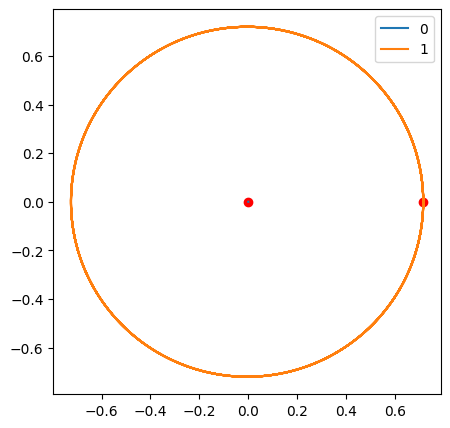

In [6]:
# Plot orbit
plt.figure(figsize=(5,5))
for i in range(len(radii)):
    plt.plot(positions_x[0,i],positions_y[0,i],c='r',ls='none',marker='o')
    plt.plot(positions_x[:,i],positions_y[:,i],label=i)
plt.legend()

## Step 2: Create lightcurves using lightcurves.py

In [7]:
from lightcurve import LightCurve

LC = LightCurve(radii_objects=radii,rad_unit="REarth",dist_unit="AU",xgrid=time)
objects = LC.compute_lightcurve(positions_x.copy(),positions_y.copy(),names)

## Step 3: Compute TTVs using ttv.py

In [8]:
from ttv import TransitTimingVariations
TTVinit = TransitTimingVariations(objects,1e3,"venus")

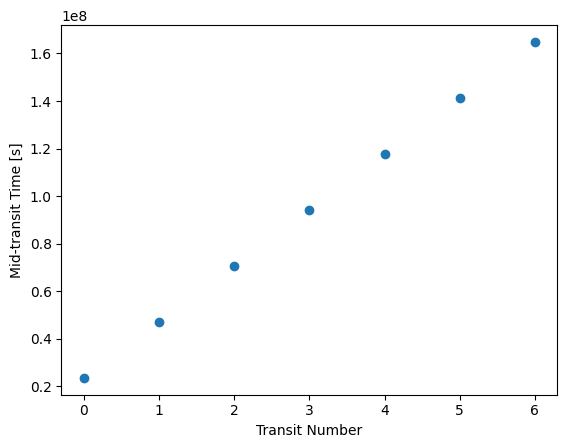

In [9]:
MTTs = TTVinit.compute_MTTs(plotfig=True,method="interpolate")

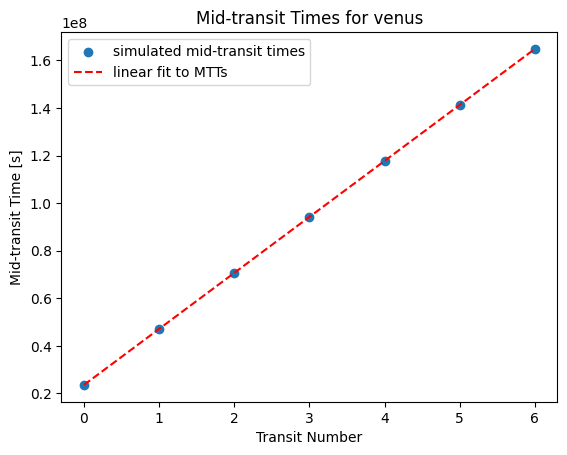

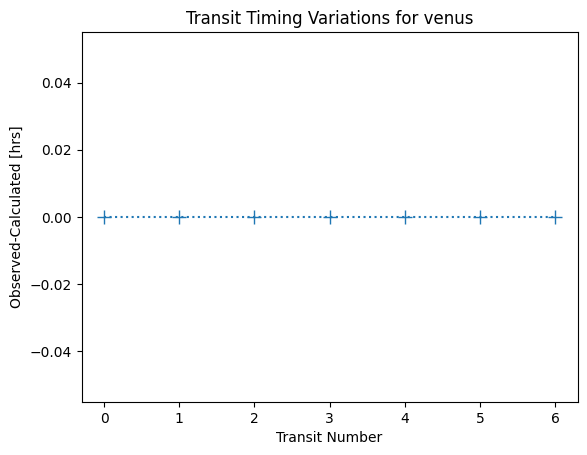

In [10]:
TTVs = TTVinit.compute_TTVs(plotfig=True,plot_time_units="hrs")